In [0]:
import keras
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import pickle
import os
import numpy as np
import glob
import cv2
from sklearn import metrics
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


Based on code borrowed (showOrigDec helper function and Autoencoder architecture) from https://github.com/shibuiwilliam/Keras_Autoencoder/blob/master/Cifar_Conv_AutoEncoder.ipynb



In [0]:
# definition to show original image and reconstructed image

def showOrigDec(rows,cols, orig,gt_images, dec, num=3):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(40, 8))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        
        
        plt.imshow(orig[i].reshape(rows, cols,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i +1 + n)
        temp = gt_images[i].reshape(rows, cols)*255
        plt.imshow(temp)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        
        # display reconstruction
        ax = plt.subplot(3, n, i +1 + 2*n)
        temp = dec[i].reshape(rows, cols)*255
#         print(temp)
#         temp = 1.0 - temp
        plt.imshow(temp)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

In [0]:
# Binarizes a given images, based on the provided Threshold
def binarize(images, threshold, normalized=True):
    output = []
    for img in images:
        if normalized:
            img *= 255
        out = np.zeros(img.shape)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] > threshold:
                    out[i][j] = 255
                else:
                    out[i][j] = 0
        output.append(out)
    return np.array(output, dtype='uint8')

In [0]:
# Getting the dataset, change the zip folder name to download the dataset of your choice
!wget http://jacarini.dinf.usherbrooke.ca/static/dataset/baseline/highway.zip

--2018-11-16 04:46:46--  http://jacarini.dinf.usherbrooke.ca/static/dataset/baseline/highway.zip
Resolving jacarini.dinf.usherbrooke.ca (jacarini.dinf.usherbrooke.ca)... 132.210.238.218
Connecting to jacarini.dinf.usherbrooke.ca (jacarini.dinf.usherbrooke.ca)|132.210.238.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27834143 (27M) [application/zip]
Saving to: ‘highway.zip.2’

highway.zip.2       100%[===================>]  26.54M  11.6MB/s    in 2.3s    

2018-11-16 04:46:49 (11.6 MB/s) - ‘highway.zip.2’ saved [27834143/27834143]



In [0]:
folder_name = 'highway'

In [0]:
!unzip -q $folder_name'.zip'

replace highway/groundtruth/gt000001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Getting the frame numbers which will be used to calculate score

with open(folder_name+"/temporalROI.txt") as f:
  parse = f.read().split()
  start_index, end_index = int(parse[0]), int(parse[1])

In [0]:
# Setting the batch size and creating folder to store models...
batch_size = 32
saveDir = "./autoencoder_model_{}/".format(folder_name)
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [0]:
# Getting the input and the associated ground truth filenames and sorting them to make sure that the inputs are mapped to their groundtruths correctly

inp_file_names = glob.glob("./{}/input/*.jpg".format(folder_name))
inp_file_names.sort()
                           
gt_file_names = glob.glob("./{}/groundtruth/*.png".format(folder_name))
gt_file_names.sort()

In [0]:
all_inp_img = []             # List of input images stored in matrix format

# Selecting only the desired frames and ground truths, whose index was imported from temporalROI file.

for ind, img in enumerate((inp_file_names), start=1):
    if ind >= start_index and ind <= end_index:
      all_inp_img.append(cv2.imread(img))
      
all_inp_img = np.array(all_inp_img)   # Convert list to array

all_gt_img = [] # List of groundTruth images stored in matrix format

                          
for ind, img in enumerate((gt_file_names), start=1):
  if ind >= start_index and ind <= end_index:
    all_gt_img.append(cv2.threshold(cv2.imread(img, 0), 200, 255,cv2.THRESH_BINARY)[1])        # Binarize groundTruth

all_gt_img = np.array(all_gt_img)

In [0]:
# Making the train-test Split
import math
train_num = math.ceil(0.8 * all_inp_img.shape[0])

In [0]:
all_inp_img.shape

(1231, 240, 320, 3)

In [0]:
# Doing the actual train test split
inp_img = all_inp_img[:train_num]
gt_img = all_gt_img[:train_num]

inp_val_img = all_inp_img[train_num:]
gt_val_img = all_gt_img[train_num:]

In [0]:
del all_gt_img
del all_inp_img

In [0]:
# Converting the scale from (0 to 255) to (0 to 1) i.e. normalization

inp_img = inp_img.astype('float32')
inp_img /= 255

gt_img = gt_img.astype('float32')
gt_img /= 255

In [0]:
inp_val_img = inp_val_img.astype('float32')
inp_val_img /= 255

In [0]:
gt_val_img = gt_val_img.astype('float32')
gt_val_img /= 255

In [0]:
_, rows, cols = gt_img.shape

In [0]:
gt_img = gt_img.reshape((gt_img.shape[0], rows, cols, 1))                       # 1 is the channel
gt_val_img = gt_val_img.reshape((gt_val_img.shape[0], rows, cols, 1))

In [0]:
gt_img.shape # 985 is the no. of instances, 240 rows, 320 cols, 1 channel

(985, 240, 320, 1)

In [0]:
# Keras Model uses a Python Generator to feed images into the network
datagen = image.ImageDataGenerator()

In [0]:
# Autoencoder Architecture used:
input_img = Input(shape=(rows, cols, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), padding='same')(x)
x = BatchNormalization()(x)

decoded = Activation('sigmoid')(x)

In [0]:
#Custom f1 score function, pixel-to-pixel comparision for identify true and false positive and negatives.
def f1_score(y_true, y_pred):
    
    y_true = tf.reshape(y_true,[-1])  # Flatten the matrix
    y_pred = tf.reshape(y_pred,[-1])  # Flatten the matrix
    
    y_true = tf.cast(tf.to_int32(y_true > 0.4), "float32")  # Binarize
    
    y_pred = tf.cast(tf.to_int32(y_pred > 0.4) , "float32")  #Binarize
    
    # implicit 0.5 threshold via tf.round
    
    y_correct = y_true * y_pred              # Multiplication is equivalent to intersection, resulting in 1s (common mask points). TRUE POSITIVES
    
#     print(y_true.shape)
    
    sum_true = tf.reduce_sum(y_true, axis=0)
    sum_pred = tf.reduce_sum(y_pred, axis=0)
    sum_correct = tf.reduce_sum(y_correct, axis=0)

    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 2 * precision * recall / ( precision + recall)
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)




In [0]:
def f1_score_numpy(y_true, y_pred,thresh = 100):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    

    y_true = (y_true> (thresh/255)).astype('float32')    
    
    y_pred = (y_pred> (thresh/255)).astype('float32')    
    
    # implicit 0.5 threshold via tf.round
    
    y_correct = y_true * y_pred
    
    
    sum_true = np.sum(y_true, axis=0)
    sum_pred = np.sum(y_pred, axis=0)
    sum_correct = np.sum(y_correct, axis=0)

    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 2 * precision * recall / ( precision + recall)
    f_score = np.where(np.isnan(f_score), np.zeros_like(f_score), f_score)
    
    
    return precision,recall,np.mean(f_score)

In [0]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy',metrics = [f1_score])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 240, 320, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 240, 320, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 32)      18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 160, 32)      128       
__________

In [0]:
es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='max')
chkpt = saveDir + 'model.{epoch:02d}-{loss:.2f}-{val_loss:.2f}-{val_f1_score:.2f}F-score.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_f1_score', verbose=1, save_best_only=True, mode='max')

In [0]:
pickup_comb = np.random.randint(0, inp_img.shape[0], size=inp_img.shape[0])

inp_img = inp_img[pickup_comb]
gt_img = gt_img[pickup_comb]

pickup_comb_val = np.random.randint(0, inp_val_img.shape[0], size=inp_val_img.shape[0])

inp_val_img = inp_val_img[pickup_comb_val]
gt_val_img = gt_val_img[pickup_comb_val]


In [0]:
epochs = 30

In [0]:

bz = 32

In [0]:
history = model.fit_generator(datagen.flow(inp_img, gt_img, batch_size=bz),steps_per_epoch=len(inp_img)//bz,epochs=epochs,
                    verbose=1,
                    validation_data=datagen.flow(inp_val_img, gt_val_img,batch_size=bz),validation_steps= len(inp_val_img)//bz,
                    callbacks=[cp_cb],shuffle=True)

In [0]:
# # # load pretrained weights
model_path = "model.12-0.24-0.24.hdf5"
model.load_weights(model_path)

In [0]:
val_sample = model.predict(inp_val_img)

In [0]:
tst = val_sample.copy()

In [0]:
tst.shape

(246, 240, 320, 1)

In [0]:
tst[0].shape

(240, 320, 1)

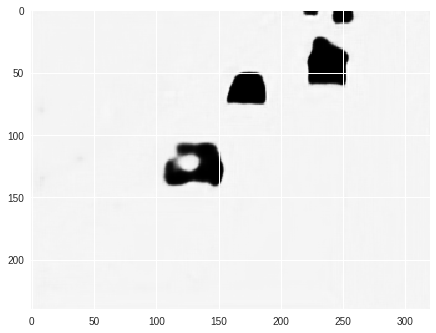

In [0]:
plt.imshow(tst[0].reshape(240, 320))

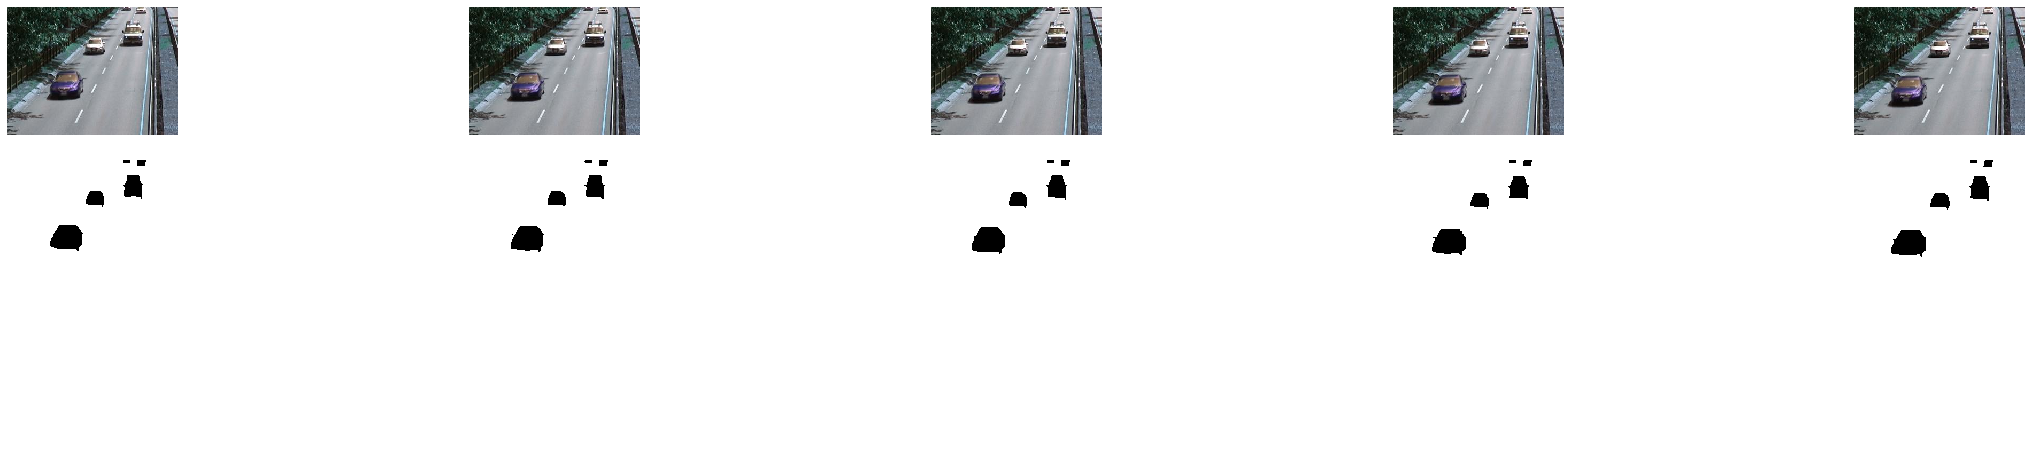

In [0]:
tst= val_sample.copy()
showOrigDec(rows,cols,inp_val_img[10:15],gt_val_img[10:15], binarize(tst[10:15], 255)*255, num=5)

In [0]:
tst= val_sample.copy()
f1_score_numpy(gt_val_img,tst,thresh = 140)

(0.9315534, 0.92123187, 0.9263638650055084)

In [0]:
# saveDir_test = "./{}_test/".format(folder_name)
# if not os.path.isdir(saveDir_test):
#     os.makedirs(saveDir_test)
    
# saveDir_test_inp = "./{}_test/input/".format(folder_name)
# if not os.path.isdir(saveDir_test_inp):
#     os.makedirs(saveDir_test_inp)
    
# saveDir_test_gt = "./{}_test/groundtruth/".format(folder_name)
# if not os.path.isdir(saveDir_test_gt):
#     os.makedirs(saveDir_test_gt)
    
# saveDir_test_preds = "./{}_test/preds/".format(folder_name)
# if not os.path.isdir(saveDir_test_preds):
#     os.makedirs(saveDir_test_preds)

In [0]:
# val_sample = model.predict(inp_val_img)
# tst= val_sample.copy()
# preds = binarize(tst, 100)*255

# import cv2


# for i, img in enumerate(inp_val_img):

#     x_true = (img.reshape(rows,cols,3))*255
#     y_true = (gt_val_img[i].reshape(rows,cols))*255
    
#     cv2.imwrite(saveDir_test_inp+str(i)+".jpg",x_true)
#     cv2.imwrite(saveDir_test_gt+str(i)+".png",y_true)
    
#     pred = (preds[i].reshape(rows,cols)) * 255
#     cv2.imwrite(saveDir_test_preds+str(i)+".png",pred)


# Results
**Video**|**Type**|**Accuracy**|**Precision**|**Recall**|**F-Score**|**Binarization Threshold**|**num\_epochs**
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
office|baseline| |0.9453622|0.9845114|0.9645397054|140| 
pedestrians|baseline| |0.9406766|0.84587264|0.8907591986|110-140|30
highway|baseline| |0.9340656635|0.9229942944|0.9273911242|120-130|30
PETS2006|baseline| |0.97310895|0.8953832|0.9326294401|110-140|30
 | | | | | | | 
overpass|dynamic| |0.8889111|0.87205935|0.8804046042|140|18
fountain01|dynamic| |0.000280571|0.016864726|0.0005519593128|140| 
fountain02|dynamic| |0.85456437|0.8150266|0.8343273254|110-140|30
canoe|dynamic| |0.9599752|0.93334115|0.9464708582|110-140|30